本章では，Fabio Gasparetti氏が公開している[News Aggregator Data Set](https://archive.ics.uci.edu/ml/datasets/News+Aggregator)を用い，ニュース記事の見出しを「ビジネス」「科学技術」「エンターテイメント」「健康」のカテゴリに分類するタスク（カテゴリ分類）に取り組む．

## 50. データの入手・整形
[News Aggregator Data Set](https://archive.ics.uci.edu/ml/datasets/News+Aggregator)をダウンロードし、以下の要領で学習データ（train.txt），検証データ（valid.txt），評価データ（test.txt）を作成せよ．
1. ダウンロードしたzipファイルを解凍し，readme.txtの説明を読む．
1. 情報源（publisher）が”Reuters”, “Huffington Post”, “Businessweek”, “Contactmusic.com”, “Daily Mail”の事例（記事）のみを抽出する．
1. 抽出された事例をランダムに並び替える．
1. 抽出された事例の80%を学習データ，残りの10%ずつを検証データと評価データに分割し，それぞれtrain.txt，valid.txt，test.txtというファイル名で保存する．ファイルには，１行に１事例を書き出すこととし，カテゴリ名と記事見出しのタブ区切り形式とせよ（このファイルは後に問題70で再利用する）．

学習データと評価データを作成したら，各カテゴリの事例数を確認せよ．

In [1]:
import re
import pandas as pd
from sklearn.model_selection import train_test_split
seed = 42

df = pd.read_table('NewsAggregatorDataset/newsCorpora.csv', header=None)
df.columns = ['ID', 'TITLE', 'URL', 'PUBLISHER', 'CATEGORY', 'STORY', 'HOSTNAME','TIMESTAMP']

df = df.query("PUBLISHER in ['Reuters', 'Huffington Post', 'Businessweek', 'Contactmusic.com', 'Daily Mail']")
df = df[['CATEGORY', 'TITLE']]
df = df.replace({'CATEGORY': {'b': 0, 't': 1, 'e': 2, 'm': 3}})
df = df.sample(frac=1, random_state=seed)

X = df.copy()
y = X['CATEGORY']

# 学習に時間がかかるので、データ数を半分に減らす
X_half, _, y_half, _ = train_test_split(X, y, test_size=0.5, stratify=y, random_state=seed)
X_train, X_vt, y_train, y_vt = train_test_split(X_half, y_half, test_size=0.2, stratify=y_half, random_state=seed)
X_valid, X_test, y_valid, y_test = train_test_split(X_vt, y_vt, test_size=0.5, stratify=y_vt, random_state=seed)

X_train.to_csv('train.txt', encoding='utf-8', sep='\t', header=False, index=False)
X_valid.to_csv('valid.txt', encoding='utf-8', sep='\t', header=False, index=False)
X_test.to_csv('test.txt', encoding='utf-8', sep='\t', header=False, index=False)


def check(path):
    with open(path, encoding='utf-8') as f:
        rows = f.readlines()
    print(path)
    print(f'  length : {len(rows)}')
    print(f'  example: {rows[0].rstrip()}')


check('train.txt')
check('valid.txt')
check('test.txt')

train.txt
  length : 5336
  example: 2	Christina Ricci fuels pregnancy rumours with billowing black blouse as she and  ...
valid.txt
  length : 667
  example: 0	UPDATE 1-ECB warns investors' gamble for profit could backfire
test.txt
  length : 667
  example: 2	Nominating Charlie Sheen For King Of The Drunk People At Taco Bell


## 51. 特徴量抽出
学習データ，検証データ，評価データから特徴量を抽出し，それぞれ`train.feature.txt`，`valid.feature.txt`，`test.feature.txt`というファイル名で保存せよ． なお，カテゴリ分類に有用そうな特徴量は各自で自由に設計せよ．記事の見出しを単語列に変換したものが最低限のベースラインとなるであろう．

In [2]:
import joblib
import pandas as pd
from sklearn.feature_extraction.text import TfidfVectorizer
cols = ['CATEGORY', 'TITLE']

train = pd.read_table('train.txt', header=None)
valid = pd.read_table('valid.txt', header=None)
test = pd.read_table('test.txt', header=None)
train.columns = cols
valid.columns = cols
test.columns = cols

vectorizer = TfidfVectorizer()
vectorizer.fit(train['TITLE'])
joblib.dump(vectorizer, 'vectorizer.joblib')
joblib.dump(vectorizer.get_feature_names(), 'vocab.joblib')

X_train = vectorizer.transform(train['TITLE'])
X_valid = vectorizer.transform(valid['TITLE'])
X_test = vectorizer.transform(test['TITLE'])

train = pd.concat([train, pd.DataFrame(X_train.toarray())], axis=1).drop(cols, axis=1)
valid = pd.concat([valid, pd.DataFrame(X_valid.toarray())], axis=1).drop(cols, axis=1)
test = pd.concat([test, pd.DataFrame(X_test.toarray())], axis=1).drop(cols, axis=1)

train.to_csv('train.feature.txt', sep='\t', header=False, index=False)
valid.to_csv('valid.feature.txt', sep='\t', header=False, index=False)
test.to_csv('test.feature.txt', sep='\t', header=False, index=False)

## 52. 学習
51で構築した学習データを用いて，ロジスティック回帰モデルを学習せよ．

In [3]:
import joblib
import pandas as pd
from sklearn.linear_model import LogisticRegression
seed = 42

X_train = pd.read_table('train.feature.txt', header=None)
y_train = pd.read_table('train.txt', header=None)[0]

clf = LogisticRegression(solver='sag', random_state=seed)
clf.fit(X_train, y_train)

joblib.dump(clf, 'clf.joblib')

['clf.joblib']

## 53. 予測
52で学習したロジスティック回帰モデルを用い，与えられた記事見出しからカテゴリとその予測確率を計算するプログラムを実装せよ．

In [4]:
import joblib

clf = joblib.load('clf.joblib')
vectorizer = joblib.load('vectorizer.joblib')

sample_title = 'Nominating Charlie Sheen For King Of The Drunk People At Taco Bell'
sample = vectorizer.transform([sample_title])

pred = clf.predict(sample)
probs = clf.predict_proba(sample)

print(f'カテゴリ: {pred}')
print(f'予測確率: {probs}')

カテゴリ: [2]
予測確率: [[0.18304772 0.07504919 0.67098184 0.07092125]]


## 54. 正解率の計測
52で学習したロジスティック回帰モデルの正解率を，学習データおよび評価データ上で計測せよ．

In [5]:
import joblib
import pandas as pd
from sklearn.metrics import accuracy_score

X_train = pd.read_table('train.feature.txt', header=None)
y_train = pd.read_table('train.txt', header=None)[0]
X_test = pd.read_table('test.feature.txt', header=None)
y_test = pd.read_table('test.txt', header=None)[0]

clf = joblib.load('clf.joblib')

preds_train = clf.predict(X_train)
acc_train = accuracy_score(y_train, preds_train)

preds_test = clf.predict(X_test)
acc_test = accuracy_score(y_test, preds_test)

print(f'学習データの正解率: {acc_train}')
print(f'評価データの正解率: {acc_test}')

学習データの正解率: 0.928223388305847
評価データの正解率: 0.8530734632683659


## 55. 混同行列の作成
52で学習したロジスティック回帰モデルの混同行列（confusion matrix）を，学習データおよび評価データ上で作成せよ．

In [6]:
import joblib
import pandas as pd
from sklearn.metrics import confusion_matrix

X_train = pd.read_table('train.feature.txt', header=None)
y_train = pd.read_table('train.txt', header=None)[0]
X_test = pd.read_table('test.feature.txt', header=None)
y_test = pd.read_table('test.txt', header=None)[0]

clf = joblib.load('clf.joblib')

preds_train = clf.predict(X_train)
cm_train = confusion_matrix(y_train, preds_train)

preds_test = clf.predict(X_test)
cm_test = confusion_matrix(y_test, preds_test)

In [7]:
print('（学習データ）左: 正解ラベル - 上: 推論結果')
pd.DataFrame(cm_train)

（学習データ）左: 正解ラベル - 上: 推論結果


,0,1,2,3
0,2204,8,37,1
1,100,431,78,1
2,10,0,2102,0
3,59,1,88,216


In [8]:
print('（評価データ）左: 正解ラベル - 上: 推論結果')
pd.DataFrame(cm_test)

（評価データ）左: 正解ラベル - 上: 推論結果


,0,1,2,3
0,263,2,16,1
1,16,39,19,2
2,10,1,253,0
3,10,2,19,14


## 56. 適合率，再現率，F1スコアの計測
52で学習したロジスティック回帰モデルの適合率，再現率，F1スコアを，評価データ上で計測せよ．カテゴリごとに適合率，再現率，F1スコアを求め，カテゴリごとの性能をマイクロ平均（micro-average）とマクロ平均（macro-average）で統合せよ．

In [9]:
import joblib
import pandas as pd
from sklearn.metrics import f1_score, precision_score, recall_score

X_test = pd.read_table('test.feature.txt', header=None)
y_test = pd.read_table('test.txt', header=None)[0]

clf = joblib.load('clf.joblib')

preds_test = clf.predict(X_test)

print(f'適合率                : {precision_score(y_test, preds_test, average=None)}')
print(f"適合率（マイクロ平均）: {precision_score(y_test, preds_test, average='micro')}")
print(f"適合率（マクロ平均）  : {precision_score(y_test, preds_test, average='macro')}")
print('-----------------')
print(f'再現率                : {recall_score(y_test, preds_test, average=None)}')
print(f"再現率（マイクロ平均）: {recall_score(y_test, preds_test, average='micro')}")
print(f"再現率（マクロ平均）  : {recall_score(y_test, preds_test, average='macro')}")
print('-----------------')
print(f'F1スコア                : {f1_score(y_test, preds_test, average=None)}')
print(f"F1スコア（マイクロ平均）: {f1_score(y_test, preds_test, average='micro')}")
print(f"F1スコア（マクロ平均）  : {f1_score(y_test, preds_test, average='macro')}")

適合率                : [0.87959866 0.88636364 0.82410423 0.82352941]
適合率（マイクロ平均）: 0.8530734632683659
適合率（マクロ平均）  : 0.8533989862158469
-----------------
再現率                : [0.93262411 0.51315789 0.95833333 0.31111111]
再現率（マイクロ平均）: 0.8530734632683659
再現率（マクロ平均）  : 0.678806613164116
-----------------
F1スコア                : [0.90533563 0.65       0.88616462 0.4516129 ]
F1スコア（マイクロ平均）: 0.8530734632683659
F1スコア（マクロ平均）  : 0.7232782887301504


## 57. 特徴量の重みの確認
52で学習したロジスティック回帰モデルの中で，重みの高い特徴量トップ10と，重みの低い特徴量トップ10を確認せよ．

In [10]:
import joblib
import pandas as pd

clf = joblib.load('clf.joblib')

vocab = joblib.load('vocab.joblib')
coef = abs(clf.coef_).mean(axis=0)
sort = sorted(zip(vocab, coef), key=lambda x: x[1])

In [11]:
print('重みの高い特徴量トップ10')
pd.DataFrame(sort[::-1][:10], columns=['単語', '特徴量'])

重みの高い特徴量トップ10


,単語,特徴量
0,google,1.871522
1,apple,1.798447
2,update,1.728699
3,ebola,1.719109
4,study,1.611939
5,facebook,1.586091
6,us,1.541002
7,microsoft,1.526177
8,climate,1.449083
9,the,1.332145


In [12]:
print('重みの低い特徴量トップ10')
pd.DataFrame(sort[:10], columns=['単語', '特徴量'])

重みの低い特徴量トップ10


,単語,特徴量
0,upstage,0.002510
1,tone,0.003544
2,donation,0.003677
3,grinds,0.004468
4,wary,0.004488
5,invitation,0.004507
6,extravagant,0.005385
7,insta,0.005385
8,nuptials,0.005385
9,picked,0.005416


## 58. 正則化パラメータの変更
ロジスティック回帰モデルを学習するとき，正則化パラメータを調整することで，学習時の過学習（overfitting）の度合いを制御できる．異なる正則化パラメータでロジスティック回帰モデルを学習し，学習データ，検証データ，および評価データ上の正解率を求めよ．実験の結果は，正則化パラメータを横軸，正解率を縦軸としたグラフにまとめよ．

学習完了 C: 0.1, 所要時間:  24秒
学習完了 C:   1, 所要時間:  33秒
学習完了 C:  10, 所要時間:  49秒


c:\users\yuich\desktop\learning\practice-nlp100\venv\lib\site-packages\sklearn\linear_model\_sag.py:328: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn("The max_iter was reached which means "


学習完了 C: 100, 所要時間:  79秒


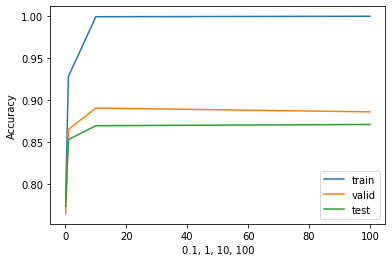

In [13]:
import time
import matplotlib.pyplot as plt
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score
%matplotlib inline
seed = 42

X_train = pd.read_table('train.feature.txt', header=None)
y_train = pd.read_table('train.txt', header=None)[0]
X_valid = pd.read_table('valid.feature.txt', header=None)
y_valid = pd.read_table('valid.txt', header=None)[0]
X_test = pd.read_table('test.feature.txt', header=None)
y_test = pd.read_table('test.txt', header=None)[0]

C_cands = [0.1, 1, 10, 100]

acc_train = []
acc_valid = []
acc_test = []
for C in C_cands:
    clf = LogisticRegression(solver='sag', C=C, random_state=seed)
    t = time.time()
    clf.fit(X_train, y_train)
    e = time.time() - t

    acc_train.append(accuracy_score(y_train, clf.predict(X_train)))
    acc_valid.append(accuracy_score(y_valid, clf.predict(X_valid)))
    acc_test.append(accuracy_score(y_test, clf.predict(X_test)))
    print(f'学習完了 C: {C:>3}, 所要時間: {int(e):>3}秒')

plt.plot(C_cands, acc_train, label='train')
plt.plot(C_cands, acc_valid, label='valid')
plt.plot(C_cands, acc_test, label='test')
plt.ylabel('Accuracy')
plt.xlabel(', '.join([str(C) for C in C_cands]))
plt.legend()
plt.show()

## 59. ハイパーパラメータの探索
学習アルゴリズムや学習パラメータを変えながら，カテゴリ分類モデルを学習せよ．検証データ上の正解率が最も高くなる学習アルゴリズム・パラメータを求めよ．また，その学習アルゴリズム・パラメータを用いたときの評価データ上の正解率を求めよ．

In [14]:
import itertools
import time
import pandas as pd
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score
seed = 42

X_train = pd.read_table('train.feature.txt', header=None)
y_train = pd.read_table('train.txt', header=None)[0]
X_valid = pd.read_table('valid.feature.txt', header=None)
y_valid = pd.read_table('valid.txt', header=None)[0]
X_test = pd.read_table('test.feature.txt', header=None)
y_test = pd.read_table('test.txt', header=None)[0]

C_cands = [0.1, 1, 10, 100]
n_estimators_cands = [100, 500, 1000]
max_depth_cands = [8, 16, 32, 64]

rows = []

for C in C_cands:
    lr = LogisticRegression(solver='sag', C=C, random_state=seed)
    t = time.time()
    lr.fit(X_train, y_train)
    e = time.time() - t

    train_acc = accuracy_score(y_train, lr.predict(X_train))
    valid_acc = accuracy_score(y_valid, lr.predict(X_valid))
    test_acc = accuracy_score(y_test, lr.predict(X_test))
    rows.append(['LogisticRegression', C, '-', '-', train_acc, valid_acc, test_acc])
    print(f'学習完了 C: {C:>3}, 所要時間: {int(e):>3}秒')
    
for n_estimators, max_depth in itertools.product(n_estimators_cands, max_depth_cands):
    rf = RandomForestClassifier(n_estimators=n_estimators, max_depth=max_depth, random_state=seed)
    t = time.time()
    rf.fit(X_train, y_train)
    e = time.time() - t

    train_acc = accuracy_score(y_train, rf.predict(X_train))
    valid_acc = accuracy_score(y_valid, rf.predict(X_valid))
    test_acc = accuracy_score(y_test, rf.predict(X_test))
    rows.append(['RandomForest', '-', n_estimators, max_depth, train_acc, valid_acc, test_acc])
    print(f'学習完了 n_estimator: {n_estimators:>4}, max_depth: {max_depth:>2}, 所要時間: {int(e):>3}秒')
    
df = pd.DataFrame(rows)
df.columns = ['アルゴリズム', 'C', 'n_estimator', 'max_depth', '正解率: 学習', '正解率: 検証', '正解率: 評価']
df

学習完了 C: 0.1, 所要時間:  24秒
学習完了 C:   1, 所要時間:  34秒
学習完了 C:  10, 所要時間:  52秒


c:\users\yuich\desktop\learning\practice-nlp100\venv\lib\site-packages\sklearn\linear_model\_sag.py:328: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn("The max_iter was reached which means "


学習完了 C: 100, 所要時間:  83秒
学習完了 n_estimator:  100, max_depth:  8, 所要時間:   1秒
学習完了 n_estimator:  100, max_depth: 16, 所要時間:   3秒
学習完了 n_estimator:  100, max_depth: 32, 所要時間:   6秒
学習完了 n_estimator:  100, max_depth: 64, 所要時間:  10秒
学習完了 n_estimator:  500, max_depth:  8, 所要時間:   6秒
学習完了 n_estimator:  500, max_depth: 16, 所要時間:  14秒
学習完了 n_estimator:  500, max_depth: 32, 所要時間:  29秒
学習完了 n_estimator:  500, max_depth: 64, 所要時間:  54秒
学習完了 n_estimator: 1000, max_depth:  8, 所要時間:  13秒
学習完了 n_estimator: 1000, max_depth: 16, 所要時間:  27秒
学習完了 n_estimator: 1000, max_depth: 32, 所要時間:  58秒
学習完了 n_estimator: 1000, max_depth: 64, 所要時間: 108秒


,アルゴリズム,C,n_estimator,max_depth,正解率: 学習,正解率: 検証,正解率: 評価
0,LogisticRegression,0.1,-,-,0.783171,0.764618,0.773613
1,LogisticRegression,1,-,-,0.928223,0.865067,0.853073
2,LogisticRegression,10,-,-,0.999250,0.890555,0.869565
3,LogisticRegression,100,-,-,0.999813,0.886057,0.871064
4,RandomForest,-,100,8,0.734820,0.706147,0.707646
5,RandomForest,-,100,16,0.741567,0.706147,0.719640
6,RandomForest,-,100,32,0.791979,0.728636,0.730135
7,RandomForest,-,100,64,0.881559,0.764618,0.766117
8,RandomForest,-,500,8,0.743253,0.703148,0.716642
9,RandomForest,-,500,16,0.749063,0.710645,0.719640
